## TERM DEPOSIT MARKETING
In this project, various bank customer data such as age, job, marital status, education etc. are used to predict if a customer will subscribe to a term deposit account or not.   

Following are the attributes of the datset   
   
age : age of customer (numeric)   
job : type of job (categorical)   
marital : marital status (categorical)   
education (categorical)   
default: has credit in default? (binary)   
balance: average yearly balance, in euros (numeric)   
housing: has a housing loan? (binary)   
loan: has personal loan? (binary)   
contact: contact communication type (categorical)   
day: last contact day of the month (numeric)   
month: last contact month of year (categorical)   
duration: last contact duration, in seconds (numeric)   
campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)   
Output (desired target):   
   

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.model_selection import StratifiedKFold

In [3]:
df1 =  pd.read_csv('term-deposit-marketing-2020.csv')

In [4]:
df1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [5]:
df1.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


<AxesSubplot:xlabel='y', ylabel='count'>

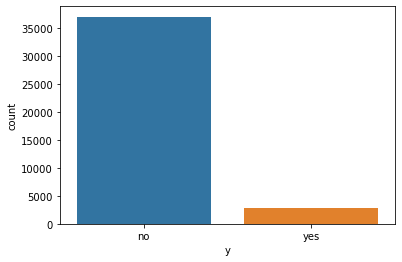

In [6]:
# The dataset is highly imbalanced. Less than 10 % are the 'yes' group (subscribed to a term deposit account)
# This is the group that is of interest to us. 
# That is, which customer characteristics will make him/her to subscribe to a term deposit account

sns.countplot(x='y', data=df1)

## Chi Square Test


Many of the features such as job, marital status, education have categorical values. One of the initial steps would be to determine if these features have any association to the outcome (i.e. said 'yes' or 'no' to a term deposit account subscription. Our null and alternate hypothesis are as follows;  
  
NULL HYPOTHESIS H0: Categorical variable tested is not a significant predictor of the outcome variable 'y'  
ALTERNATE HYPOTHESIS H1: Categorical variable tested is could be a significant predictor of the outcome variable 'y'  
  
We will use the Chi Square or the Goodness of Fit test to check the independence of these variables and a p value < 0.05 will be considered sufficient to reject the NULL HYPOTHESIS.

In [7]:
# The following function calculates the Chi Square p-value when comparing the categorical variable in list cat_var
# against the outcome variable 'y'  ('yes' or 'no')


cat_var = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'campaign']
def chi_sq (df):
    """
    INPUT : Dataframe containing categorical data for columns specified in cat_var
    The function calculates the Chi-Square p values when comparing between each of the variables and the output variable 'y'
    OUTPUT : a dataframe containing the p-values corresponding to each of the variables
    """
    p_Vals_dict = {}
    for feat in cat_var:
        cross_tab = pd.crosstab(df1[feat], df1['y'])
        chiVal, pVal,degfrdm, exp = chi2_contingency(cross_tab)
        p_Vals_dict[feat] = pVal
    
    p_Vals_df = pd.DataFrame(index = ['Job Type', 'Marital Status', 'Education Level', 'Default History', 
                                      'Housing Loan', 'Personal Loan', 'Contact Method', 'Last Contact Day', 
                                      'Last Contact Month', 'Number of Contacts'], 
                             data = p_Vals_dict.values(), columns = ['p-value'])
    return p_Vals_df
    

In [8]:
chi_sq(df1)

,p-value
Job Type,1.676135e-26
Marital Status,3.091031e-30
Education Level,8.061911e-21
Default History,2.137353e-01
Housing Loan,2.048343e-27
Personal Loan,6.395487e-10
Contact Method,7.242047e-71
Last Contact Day,4.733110e-70
Last Contact Month,0.000000e+00
Number of Contacts,5.174950e-06


With the exception of default history, the p value is less than 0.05 for all the categorical features tested. This indicates that, for those features, we can safely reject the null hypothesis. That is, these features are not a significant predictor of the choice of a customer to sign up for a term deposit account (or not). However, default history appears to be a predictor of a customers' choice (or the bank will not consider applications of customers with a history of default).

## Feature Engineering
Convert the categorical variables with text into dummy variables.

In [9]:
# make a deep copy of df1
df2 = df1.copy()

In [10]:
# replace all 'no's with 0 and 'yes' with 1 in the whole dataframe
df2.replace({'no':0, 'yes':1}, inplace = True)

In [11]:
df2.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


In [12]:
#create dummy columns for the following columns, and drop the first of the dummy columns
df3 = pd.get_dummies(df2, columns=['job','marital','month','education','contact', 'day'], drop_first=True)

In [13]:
df3.head()

,age,default,balance,housing,loan,duration,campaign,y,job_blue-collar,job_entrepreneur,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,58,0,2143,1,0,261,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,44,0,29,1,0,151,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33,0,2,1,1,76,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,47,0,1506,1,0,92,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,1,0,0,198,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# specify dependent and independent variables
X = df3.drop('y', axis=1)
y = df3['y']

## DATA REBALANCING BY OVER OR UNDERSAMPLING
As we have already seen, the dataset is heavily imbalanced in favour of the 'no' group (i.e. those who do not subscribe to a term deposit account). We will rebalance the data using random undersampling, random oversampling and SMOTE oversampling (that uses the K-Nearest Neighbour (KNN) method to resample data points). 

In [15]:
class_0_count, class_1_count = df3['y'].value_counts() # the 'no' (0) group is about 13 fold larger than the 'yes' (1) group 
class_0_count, class_1_count

(37104, 2896)

In [16]:
#create an instance of Stratified K Fold with 5 splits
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = True)

## 1) Random undersampling of the majority class

In [17]:
#undersample the 'no' (0) group to equal the 'yes' (1) group and concatenate the new 'no' group to the 'yes' group 
class_0_undersample = pd.concat([df3[df3['y']==0].sample(class_1_count), df3[df3['y']==1]], axis = 0, ignore_index=True)
class_0_undersample['y'].value_counts()  # the two classes are balanced in the new dataset                               

1    2896
0    2896
Name: y, dtype: int64

In [18]:
# Specify X and y of the undersampled datset for training the model
X_class_0_undersample = class_0_undersample.drop('y', axis=1)
y_class_0_undersample = class_0_undersample['y']

## 2) Random oversampling of the minority class

In [19]:
#oversample the 'yes' (1) group to equal the 'no' (0) group (simple replication of datapoints) and concatenate the new 'yes' group to the 'no' group 
class_1_oversample = pd.concat([df3[df3['y']==0], df3[df3['y']==1].sample(class_0_count, replace=True)], axis = 0, ignore_index=True)
class_1_oversample['y'].value_counts() # the two classes are balanced in the new dataset 

1    37104
0    37104
Name: y, dtype: int64

In [20]:
# Specify X and y of the oversampled datset for training the model
X_class_1_oversample = class_1_oversample.drop('y', axis = 1)
y_class_1_oversample = class_1_oversample['y']

In [29]:
X_class_1_oversample.head(2)

,age,default,balance,housing,loan,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,58,0,2143,1,0,261,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,44,0,29,1,0,151,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3) SMOTE oversampling of the minority class

In [22]:
#create an instance of SMOTE and specify the minority class tobe resampled
smote = SMOTE(sampling_strategy = 'minority')
X_train_sm, y_train_sm = smote.fit_resample(df3.drop('y', axis=1), df3['y'])

In [23]:
y_train_sm.value_counts() # after resampling, the two groups in the training set are now balanced.

1    37104
0    37104
Name: y, dtype: int64

## Define function to conduct stratified K-fold validation

In [24]:
#create an instance of Stratified K Fold with 5 splits
def K_fold_validation (X ,y):
    skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = True)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, learning_rate=0.4, max_depth = 5)
    
    score_dict = {}
    
    train_accuracy = []
    test_accuracy = []
    precision_gp0 = []
    precision_gp1 = []
    recall_gp0 = []
    recall_gp1 = []
    f1_gp0 = []
    f1_gp1 = []
    for train_index, test_index in skf.split(X, y):
        X_train = X.loc[train_index].values
        y_train = y.loc[train_index].values
        X_test = X.loc[test_index].values
        y_test = y.loc[test_index].values
        
        xgb.fit(X_train, y_train)
        
        train_pred = xgb.predict(X_train)
        test_pred = xgb.predict(X_test)
        
        train_accuracy.append(accuracy_score(y_train, train_pred))
        test_accuracy.append(accuracy_score(y_test, test_pred))
        precision_gp0.append(precision_score(y_test, test_pred, average=None)[0])
        precision_gp1.append(precision_score(y_test, test_pred, average=None)[1])
        recall_gp0.append(recall_score(y_test, test_pred, average=None)[0])
        recall_gp1.append(recall_score(y_test, test_pred, average=None)[1])
        f1_gp0.append(f1_score(y_test, test_pred, average=None)[0])
        f1_gp1.append(f1_score(y_test, test_pred, average=None)[1])
        
    score_dict['Train Accuracy'] = np.mean(train_accuracy)
    score_dict['Test Accuracy'] = np.mean(test_accuracy)
    score_dict['Precision GP 0'] = np.mean(precision_gp0)
    score_dict['Precision GP 1'] = np.mean(precision_gp1)
    score_dict['Recall GP 0'] = np.mean(recall_gp0)
    score_dict['Recall GP 1'] = np.mean(recall_gp1)
    score_dict['F1 Sore GP 0'] = np.mean(f1_gp0)
    score_dict['F1 Sore GP 1'] = np.mean(f1_gp1)

    df_metrics=pd.DataFrame(score_dict.items(), columns=['', 'score'])
    return df_metrics.set_index('')

## Conduct K-Fold validation with unbalanced data

In [25]:
unbalanced_data = K_fold_validation(X, y)
unbalanced_data

,score
,
Train Accuracy,0.968919
Test Accuracy,0.934975
Precision GP 0,0.954048
Precision GP 1,0.574032
Recall GP 0,0.976957
Recall GP 1,0.397103
F1 Sore GP 0,0.965365
F1 Sore GP 1,0.469258


The train and test accuracies are very good, however, all other metrics for the 'no' group are poor compared to the 'yes' group. This indicates that the XGB Classifier model is having trouble predicting the 'no' group, likely due to its under-representation.

## Conduct K-Fold validation with SMOTE oversampled data

In [26]:
smote_method = K_fold_validation(X_train_sm, y_train_sm)
smote_method

,score
,
Train Accuracy,0.978860
Test Accuracy,0.963212
Precision GP 0,0.960166
Precision GP 1,0.966309
Recall GP 0,0.966527
Recall GP 1,0.959896
F1 Sore GP 0,0.963333
F1 Sore GP 1,0.963089


SMOTE oversampling significantly improved all the metrics for the 'no' group 

## Conduct K-Fold validation with randomly oversampled data

In [27]:
random_over = K_fold_validation(X_class_1_oversample, y_class_1_oversample)
random_over

,score
,
Train Accuracy,0.952967
Test Accuracy,0.942472
Precision GP 0,0.982494
Precision GP 1,0.908593
Recall GP 0,0.901008
Recall GP 1,0.983937
F1 Sore GP 0,0.939984
F1 Sore GP 1,0.944762


Random oversampling also improved all the metrics for the 'no' group.

## Conduct K-Fold validation with randomly undersampled data

In [28]:
random_under = K_fold_validation(X_class_0_undersample, y_class_0_undersample)
random_under

,score
,
Train Accuracy,0.979368
Test Accuracy,0.880699
Precision GP 0,0.899269
Precision GP 1,0.863951
Recall GP 0,0.857388
Recall GP 1,0.904008
F1 Sore GP 0,0.877772
F1 Sore GP 1,0.883476


Random undersampling also improved the 'no' group metrics but to a lesser extent while at the same time decreased the metrics of the 'yes' group. This indicates that SMOTE oversampling or random oversampling yields the best predictive capability for the XGB model using this dataset.